# Notebook Prep

Berikut adalah module python yang diperlukan

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import Input, Model, layers, models
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import psycopg2
from psycopg2 import Error

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Data Loading

Setelah menyiapkan notebook, tentu akan dilakukan data loading untuk memuat data yang nantinya akan di eksplore

In [16]:
try:
    # Connect to an existing database
    connection = psycopg2.connect(user="user",
                                  password="batugin2",
                                  host="34.101.98.206",
                                  port="5432",
                                  database="dwh-supplychain")

    # Create a cursor to perform database operations
    cursor = connection.cursor()
    # Print PostgreSQL details
    print("PostgreSQL server information")
    print(connection.get_dsn_parameters(), "\n")
    # Executing a SQL query
    cursor.execute("SELECT version();")
    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)

cursor.execute('''SELECT plant, plant_description, posting_date, material, bill_qty_sku, material_desc FROM v_sales_2021''')
data = cursor.fetchall()

col = []
for elt in cursor.description:
    col.append(elt[0])

df=pd.DataFrame(data=data, columns=col)
df.info()
df.head()

PostgreSQL server information
{'user': 'user', 'channel_binding': 'prefer', 'dbname': 'dwh-supplychain', 'host': '34.101.98.206', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.4 on x86_64-pc-linux-gnu, compiled by Debian clang version 12.0.1, 64-bit',) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841600 entries, 0 to 841599
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   plant              841600 non-null  object
 1   plant_description  841600 non-null  object
 2   posting_date       841600 non-null  object
 3   material           841600 non-null  object
 4   bill_qty_sku       841600 non-null  object
 5   material_desc      841600 non-null  object
dtypes: object(6)
memory usage: 38.5+ MB


,plant,plant_description,posting_date,material,bill_qty_sku,material_desc
0,2201,KFTD Aceh,2021-02-26,11000147,300.00,AMBROXOL 30 MG (DUS 100 TAB)
1,2202,KFTD Medan,2021-02-25,11000072,10000.00,GLIBENCLAMIDE 5 MG (DUS 100 TAB)
2,2202,KFTD Medan,2021-02-25,11000113,6000.00,NITROKAF RETARD KAPSUL (DUS 100 KPS)
3,2202,KFTD Medan,2021-02-25,11000113,1000.00,NITROKAF RETARD KAPSUL (DUS 100 KPS)
4,2202,KFTD Medan,2021-02-25,11000000,200.00,ACICLOVIR 200 MG (DUS 100 TAB)


Diatas adalah kode yang digunakan untuk melakukan koneksi ke database PostgreSQL dan melakukan data fetch sesuai SQL Query tersebut, yang nantinya disimpan pada sebuah pandas DataFrame, dan juga ditampilkan informasi terkait DataFrame tersebut

# Exploratory Data Analysis

Setelah dilakukan Data Loading, lalu dilakukan Exploratory Data Analysis (EDA). Setelah dilakukan data Fetch, dapat dilihat pada tipe data dan juga karena disebelumnya sudah dicetak 10 baris awal. Dapat dilihat beberapa data ada yang tidak sesuai dengan jenis datanya. Maka dengan kode dibawah diubah menjadi tipe data yang sesuai

In [17]:
df['date'] = pd.to_datetime(df['posting_date'])
df['material'] = df['material'].astype(np.int64)
df['sale_qty'] = df['bill_qty_sku'].astype(np.int64)
df = df.drop(['posting_date', 'bill_qty_sku'], axis=1)
df['plant'] = df['plant'].astype(np.int64)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841600 entries, 0 to 841599
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   plant              841600 non-null  int64         
 1   plant_description  841600 non-null  object        
 2   material           841600 non-null  int64         
 3   material_desc      841600 non-null  object        
 4   date               841600 non-null  datetime64[ns]
 5   sale_qty           841600 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 38.5+ MB


,plant,plant_description,material,material_desc,date,sale_qty
0,2201,KFTD Aceh,11000147,AMBROXOL 30 MG (DUS 100 TAB),2021-02-26,300
1,2202,KFTD Medan,11000072,GLIBENCLAMIDE 5 MG (DUS 100 TAB),2021-02-25,10000
2,2202,KFTD Medan,11000113,NITROKAF RETARD KAPSUL (DUS 100 KPS),2021-02-25,6000
3,2202,KFTD Medan,11000113,NITROKAF RETARD KAPSUL (DUS 100 KPS),2021-02-25,1000
4,2202,KFTD Medan,11000000,ACICLOVIR 200 MG (DUS 100 TAB),2021-02-25,200
5,2202,KFTD Medan,11000391,GENTAMYCIN 0.1 % (DUS 10 TUBE @ 5 GRAM),2021-02-25,20
6,2202,KFTD Medan,11000216,KINA (DUS 24 STRIP),2021-02-25,288
7,2202,KFTD Medan,11000296,MICONAZOLE 2 % CR(DUS 24 TUBE@10 GRAM),2021-02-25,24
8,2202,KFTD Medan,11000391,GENTAMYCIN 0.1 % (DUS 10 TUBE @ 5 GRAM),2021-02-25,10
9,2202,KFTD Medan,11000384,BETASON N CREAM (DUS 24 TUB @5 G),2021-02-25,11


Setelah diubah menjadi tipe data yang sesuai. Perlu diketahui karakteristik data tersebut, dengan menggunakan describe() function dapat dilihat beberapa karakteristik data seperti count, mean, dan standard deviation.

In [18]:
df.describe()

,plant,material,sale_qty
count,841600.000000,8.416000e+05,8.416000e+05
mean,2175.580271,1.100050e+07,1.432382e+03
std,215.993254,5.781524e+02,2.062117e+04
min,1201.000000,1.100000e+07,-8.904000e+05
25%,2213.000000,1.100015e+07,1.000000e+01
50%,2222.000000,1.100030e+07,1.000000e+02
75%,2232.000000,1.100049e+07,3.360000e+02
max,2248.000000,1.100220e+07,1.370400e+07


Dari data diatas yang perlu dilihat adalah kolom bill_qty_sku yang mana merupakan jumlah penjualan. dapat dilihat pada 75th percentile jika dibandingkan dengan max nya dapat dilihat perbedaan nilai yang sangat besar, dari hal ini dapat diketahui bahwa pada data tersebut terdapat sebuah outlier yang artinya dalam data tersebut ada nilai yang perbedaannya terlampau tinggi yang dapat menyebabkan analisa data menjadi sulit.

Setelah itu kita juga perlu melihat apakah terdapat nilai kosong

<Axes: >

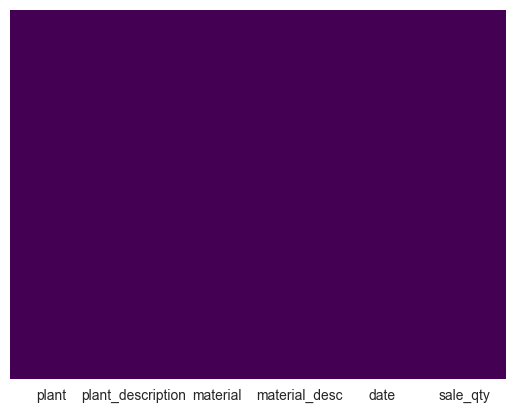

In [19]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

Dapat dilihat bahwa tidak terdapat nilai kosong pada data tersebut. Lalu dapat dilakukan pengecekan terhadap sebaran penjualan perhari tiap material, dan tiap plant

Lalu perlu dilihat terkait bagaimana visualisasi data tersebut sehingga didapatkan gambaran yang lebih luas atas data tersebut.

In [20]:
plant_daily = df.groupby(['plant','date'], as_index=False)['sale_qty'].sum()
material_daily = df.groupby(['material','date'], as_index=False)['sale_qty'].sum()
daily = df.groupby(['date'], as_index=False)['sale_qty'].sum()

In [21]:
daily_sales_sc = go.Scatter(x=daily['date'], y=daily['sale_qty'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Diatas merupakan grafik penjualan perhari keseluruhan. Dapat dilihat bahwa terdapat spike pada data yang dilihat sebelumnya pada max value yang jauh lebih tinggi dibanding 75th percentile.

In [ ]:
plant_daily_sc = []
for plant in plant_daily['plant'].unique():
    current_plant_daily_sales = plant_daily[(plant_daily['plant'] == plant)]
    plant_daily_sc.append(go.Scatter(x=current_plant_daily_sales['date'], y=current_plant_daily_sales['sale_qty'], name=('Plant %s' % plant)))

layout = go.Layout(title='plant daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=plant_daily_sc, layout=layout)
iplot(fig)

Ditas adalah grafik penjualan perhari dari setiap plant. Dapat dilihat terdapat outlier pada data plant 1201

In [ ]:
material_daily_sc = []
for material in material_daily['material'].unique():
    current_material_daily_sales = material_daily[(material_daily['material'] == material)]
    material_daily_sc.append(go.Scatter(x=current_material_daily_sales['date'], y=current_material_daily_sales['sale_qty'], name=('Material %s' % material)))

layout = go.Layout(title='material daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=material_daily_sc, layout=layout)
iplot(fig)

Dapat dilihat pada grafik diatas yang merupakan grafik penjualan per hari tiap material.

Setelah melihat grafik - grafik diatas, perlu di lakukan pengamatan lebih dalam pada data plant 1201

In [ ]:
df_1201 = df.loc[(df['plant'] == 1201)].copy()
df_1201 = df_1201.groupby(['material','date'], as_index=False)['sale_qty'].sum()

material_daily_sc = []
for material in df_1201['material'].unique():
    current_material_daily_sales = df_1201[(df_1201['material'] == material)]
    material_daily_sc.append(go.Scatter(x=current_material_daily_sales['date'], y=current_material_daily_sales['sale_qty'], name=('Material %s' % material)))

layout = go.Layout(title='1201 material daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=material_daily_sc, layout=layout)
iplot(fig)

Dapat dilihat dari grafik diatas terdapat spike yang cukup tinggi pada tanggal 16 Maret 2021, dan juga pada tanggal 31 May 2021, Hal tersebut lah yang merupakan outlier pada data tersebut. Dengan mengetahui karakteristik data dan juga dikarenakan daat tersebut merupakan data penjualan maka data tersebut tidak dapat dihapus dikarenakan menyimpan detail harian yang dapat terjadi dikemudian harinya, sehingga untuk mengatasi permaslahan tersebut ketika training maka perlu digunakan loss function yang menangani hal - hal seperti itu dengan baik. Salah satunya dan yang akan digunakan adalah Hubber Loss Function, yang merupakan gabungan dari MSE (Mean Squared Error) dan MAE (Mean Absolute Error)

# Data Cleaning

Dalam melakukan analisa big data, Data Cleaning merupakan salah satu step paling krusial dalam mendapatkan hasil analisa yang baik dan dapat digunakan. Sehingga langkah pertama dalam melakukan data analysis itu adalah Data Cleaning

Setelah itu data dikelompokkan menjadi beberapa kelompok, yaitu kelompok yang diurutkan berdasar 'material' dan 'posting_date'. Dan berdasarkan 'material', 'plant', dan 'posting_date'. Kelompok pertama digunakan untuk melakukan analisa performa sebuah barang secara umum. Sedangkan kelompok kedua digunakan untuk melakukan analisa performa sebuah barang pada plant tertentu

In [22]:
material_df = df.groupby(['material','date']).agg({'sale_qty':'sum', 'material':'first', 'date':'first'})
material_df.info()
material_df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 39961 entries, (11000000, Timestamp('2021-01-07 00:00:00')) to (11002204, Timestamp('2021-05-11 00:00:00'))
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   sale_qty  39961 non-null  int64         
 1   material  39961 non-null  int64         
 2   date      39961 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.0 MB


sale_qty  material       date
material date                                     
11000000 2021-01-07       100  11000000 2021-01-07
         2021-01-08      1900  11000000 2021-01-08
         2021-01-09      2700  11000000 2021-01-09
         2021-01-11      5700  11000000 2021-01-11
         2021-01-12     23200  11000000 2021-01-12
         2021-01-13      4700  11000000 2021-01-13
         2021-01-14      7200  11000000 2021-01-14
         2021-01-15      6800  11000000 2021-01-15
         2021-01-16      1000  11000000 2021-01-16
         2021-01-18      1100  11000000 2021-01-18

In [23]:
plant_df = df.groupby(['plant','material','date']).agg({'sale_qty':'sum', 'material':'first', 'date':'first', 'plant':'first'})
plant_df.info()
plant_df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 354779 entries, (1201, 11000000, Timestamp('2021-01-21 00:00:00')) to (2248, 11002125, Timestamp('2021-04-16 00:00:00'))
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   sale_qty  354779 non-null  int64         
 1   material  354779 non-null  int64         
 2   date      354779 non-null  datetime64[ns]
 3   plant     354779 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 12.2 MB


sale_qty  material       date  plant
plant material date                                            
1201  11000000 2021-01-21     65000  11000000 2021-01-21   1201
               2021-01-22     31000  11000000 2021-01-22   1201
               2021-01-25     26100  11000000 2021-01-25   1201
               2021-01-26     22600  11000000 2021-01-26   1201
               2021-01-27      2000  11000000 2021-01-27   1201
               2021-01-29    123400  11000000 2021-01-29   1201
               2021-02-02     41900  11000000 2021-02-02   1201
               2021-02-04     13000  11000000 2021-02-04   1201
               2021-02-05      5000  11000000 2021-02-05   1201
               2021-02-08     23200  11000000 2021-02-08   1201

Tentu saja untuk membantu analisa diperlukan list - list dari nama material dan juga nama dari plant. Untuk itu dapat diambil dari DataFrame yang sudah dibuat di pertama tadi

In [24]:
material_list = df.groupby(['material']).agg({'material':'first','material_desc':'first'})
material_list.info()
material_list.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549 entries, 11000000 to 11002204
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   material       549 non-null    int64 
 1   material_desc  549 non-null    object
dtypes: int64(1), object(1)
memory usage: 12.9+ KB


,material,material_desc
material,,
11000000,11000000,ACICLOVIR 200 MG (DUS 100 TAB)
11000002,11000002,ACICLOVIR 400 MG (DUS 100 TAB)
11000004,11000004,ACICLOVIR CREAM 5%(DUS 25 TUBE @ 5 GRAM)
11000006,11000006,ALERGINE 10 MG TSS (DUS 50 TAB)
11000008,11000008,ALPRAZOLAM 0.5 MG (DUS 100 TAB)
11000009,11000009,ALPRAZOLAM 1 MG (DUS 100 TAB)
11000011,11000011,AMOXICILLIN 500 MG (DUS 100 TAB)
11000012,11000012,AMPICILLIN 500 MG (DUS 100 TAB)
11000013,11000013,ANTASIDA DOEN SUSPENSI (BTL 60 ML)


In [25]:
plant_list = df.groupby(['plant']).agg({'plant':'first','plant_description':'first'})
plant_list.info()
plant_list.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1201 to 2248
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   plant              50 non-null     int64 
 1   plant_description  50 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


,plant,plant_description
plant,,
1201,1201,Unit Logistik Sentral
2101,2101,KFTD Unit Bisnis Pusat
2201,2201,KFTD Aceh
2202,2202,KFTD Medan
2203,2203,KFTD Pematangsiantar
2204,2204,KFTD Padang
2205,2205,KFTD Pekanbaru
2206,2206,KFTD Batam
2207,2207,KFTD Jambi


Dengan demikian proses data fetch dan data cleaning sudah selesai. Selanjutnya akan dilanjutkan dengan data preprocessing

# Data Preprocessing

Sebelum diinputkan ke dalam machine learning mode, data tentu saja perlu dipreprocess terlebih dahulu, terutama apabila menggunakan model LSTM ( Long-Short Term Memory). Berikut adalah tahapan preprocess yang digunakan

Sebagai contoh, akan dilakukan model training dengan menggunakan data Sale Qty dari material_id = 11000267

In [26]:
train_data = material_df.reset_index(drop=True)
train_data = train_data.loc[(train_data['material']==11000267)].copy()
train_data= train_data.drop(['material','date'],axis=1)
train_data = train_data.reset_index(drop=True)
train_data.info()
train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sale_qty  70 non-null     int64
dtypes: int64(1)
memory usage: 688.0 bytes


,sale_qty
0,390
1,60
2,30
3,30
4,210
...,...
65,30
66,1080
67,90
68,660


Pada kode diatas, nilai dari material.df disimpan pada sebuah DataFrame baru lalu dikelompokkan sehingga nilai dari 'sale_qty' adalah jumlah dari penjualan sehari. Lalu untuk menggunakannya sebagai data input bagi model, maka dihapus kolom 'posting_date' dan 'material'.

Setelah itu train_data dapat di preprocess sesuai dengan model LSTM, pada model LSTM yang digunakan terdapat aturan ukuran input dengan format [n_input, n_feature], n_input adalah jumlah langkah yang digunakan untuk memprediksi, n_feature adalah jumlah target yang ingin diprediksi.

In [27]:
train = train_data[:-15]
test = train_data[-30:]
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
n_input = 30
n_feature = 1
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=batch_size)

Dan karena pada LSTM menerima input yang berada dikisaran 0 hingga 1, maka perlu dilakukan scaling terhadap train_data dengan menggunakan sklearn.preprocessing.MinMaxScaler yang nantinya hasil dari scaling di jadikan input untuk generator yang akan men-generate data sebagai input untuk model training sesuai dengan yang ukuran yang dibutuhkan yaitu (10,1)

# Training

Setelah data generator disiapkan, maka dapat dilakukan pembuatan model LSTM yang akan digunakan

In [28]:
huber_loss = tf.keras.losses.Huber(delta=1.25)

def TesNet():
    inputs = Input(shape=(30,1))
    x = layers.LSTM(100)(inputs)
    x = layers.Activation('relu')(x)
    outputs = layers.Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = TesNet()
model.compile(loss=huber_loss, optimizer = keras.optimizers.Adam(1e-3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Dapat dilihat pada kode diatas bahwa model LSTM yang digunakan terdiri dari layer input, lalu layer LSTM dengan 100 neuron, lalu layer Dense yang menjadi output layer dari model ini. Model ini juga menerima input berukuran (10,1).

Lalu dalam melakukan training tentu saja perlu dilakukan beberapa hal untuk menghindari Overfitting, Overfitting sendiri adalah kondisi dimana model menjadi terlalu terlatih untuk input yang diberikan saat training sehingga memiliki nilai loss yang sangat rendah tetapi ketika di tes ke data yang belum pernah di inputkan saat training memiliki loss yang sangat tinggi. Hal tersebut dapat di hindarkan dengan cara menggunakan callbacks, pada notebook ini yang digunakan adalah metode EarlyStopping dan LRDecay, EarlyStopping merupakan callbacks yang builtin dari tensorflow.keras yang memantau nilai loss apabila tidak terjadi perubahan signifikan selama waktu yang ditentukan maka proses training dianggap sudah selesai. Lalu LRDecay (Learning Rate Decay) adalah metode dimana berdasar banyak epoch yang sudah dilakukan learning rate dari model di ubah untuk menghindari learning rate terlalu tinggi.

In [29]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 175:
        lr *= 0.5e-4
    elif epoch > 100:
        lr *= 1e-3
    elif epoch > 50:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
    # if epoch < 40:
    #   return 0.01
    # else:
    #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay

stop = EarlyStopping(
    monitor='loss',
    patience=10,
    min_delta=0.01,
    mode='max',
    restore_best_weights=True)

Setelah disiapkan Callbacks yang diperlukan maka dapat dilakukan untuk training

In [30]:
model.fit(generator, epochs = 125, callbacks=[lrdecay, stop])

Epoch 1/125
25/25 [==============================] - 5s 7ms/step - loss: 0.0108 - lr: 0.0010
Epoch 2/125
25/25 [==============================] - 0s 7ms/step - loss: 0.0099 - lr: 0.0010
Epoch 3/125
25/25 [==============================] - 0s 6ms/step - loss: 0.0103 - lr: 0.0010
Epoch 4/125
25/25 [==============================] - 0s 6ms/step - loss: 0.0109 - lr: 0.0010
Epoch 5/125
25/25 [==============================] - 0s 6ms/step - loss: 0.0099 - lr: 0.0010
Epoch 6/125
25/25 [==============================] - 0s 6ms/step - loss: 0.0096 - lr: 0.0010
Epoch 7/125
25/25 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 8/125
25/25 [==============================] - 0s 5ms/step - loss: 0.0094 - lr: 0.0010
Epoch 9/125
25/25 [==============================] - 0s 5ms/step - loss: 0.0091 - lr: 0.0010
Epoch 10/125
25/25 [==============================] - 0s 6ms/step - loss: 0.0097 - lr: 0.0010
Epoch 11/125
25/25 [==============================] - 0s 6ms/step - l

Setelah dilakukan Training terhadap model yang digunakan dapat kita lakukan test terhadap data set yang belum pernah dilihat oleh model, yang nantinya dapat digunakan sebagai evaluasi terhadap performa model tersebut.

In [31]:
pred = []
first_eval_batch = scaled_train[-30:]
current_batch = first_eval_batch.reshape((1,30,1))

for i in range(30):
    current_pred = model.predict(current_batch)[0]
    pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


In [32]:
tes_res = material_df.reset_index(drop=True)
tes_res = tes_res.loc[(tes_res['material']==11000267)].copy()
tes_res = tes_res.groupby(['date']).sum()
tes_res = tes_res.drop(['material','sale_qty'], axis=1)
tes_res = tes_res[-30:]
tes_res = tes_res.reset_index()
tes_res['act_sale'] = scaled_test.astype(np.float64)
tes_res['pred_sale'] = pred
tes_res['pred_sale'] = tes_res['pred_sale'].astype(np.float64)
tes_res

,date,act_sale,pred_sale
0,2021-03-29,0.048387,0.038999
1,2021-03-30,0.064516,0.040099
2,2021-03-31,0.016129,0.040123
3,2021-04-12,0.032258,0.039427
4,2021-04-13,0.016129,0.038322
5,2021-04-14,0.548387,0.037175
6,2021-04-15,0.000000,0.035845
7,2021-04-16,0.145161,0.034567
8,2021-04-17,0.016129,0.033375
9,2021-04-19,0.048387,0.032296


In [33]:
predicted_sales_sc = go.Scatter(x=tes_res['date'], y=tes_res['pred_sale'], name='Predicted')
actual_sales_sc = go.Scatter(x=tes_res['date'], y=tes_res['act_sale'], name='Actual')
layout = go.Layout(title='Test', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[actual_sales_sc, predicted_sales_sc], layout=layout)
iplot(fig)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [35]:
rmse = np.sqrt(mean_squared_error(scaled_test, pred))
print("RMSE: ", rmse)
mse = mean_squared_error(scaled_test, pred)
print("MSE: ", mse)
mae = mean_absolute_error(scaled_test, pred)
print("MAE: ", mae)
mpe = mean_absolute_percentage_error(scaled_test, pred)
print("MPE", mpe)

RMSE:  0.2257314257521595
MSE:  0.05095467657210269
MAE:  0.11689636073005134
MPE 5381110278827.312


Dapat dilihat pada hasil prediction model ketika dibandingkan dengan hasil sebenarnya, dapat dilihat bahwa hasil prediksi model masih kurang baik oleh karena itu dilakukan training diluar notebook ini sehingga dapat langsung di load model yang sudah ditraining

In [38]:
model = tf.keras.models.load_model("E:/Program/PKLProjekt/ML/model.h5")
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_15 (LSTM)              (None, 100)               40800     
                                                                 
 activation_7 (Activation)   (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [39]:
pred = []
first_eval_batch = scaled_train[-30:]
current_batch = first_eval_batch.reshape((1,30,1))

for i in range(30):
    current_pred = model.predict(current_batch)[0]
    pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [40]:
tes_res = material_df.reset_index(drop=True)
tes_res = tes_res.loc[(tes_res['material']==11000267)].copy()
tes_res = tes_res.groupby(['date']).sum()
tes_res = tes_res.drop(['material','sale_qty'], axis=1)
tes_res = tes_res[-30:]
tes_res = tes_res.reset_index()
tes_res['act_sale'] = scaled_test.astype(np.float64)
tes_res['pred_sale'] = pred
tes_res['pred_sale'] = tes_res['pred_sale'].astype(np.float64)
tes_res

,date,act_sale,pred_sale
0,2021-03-29,0.048387,0.272153
1,2021-03-30,0.064516,0.225458
2,2021-03-31,0.016129,0.307886
3,2021-04-12,0.032258,0.101310
4,2021-04-13,0.016129,0.110384
5,2021-04-14,0.548387,0.182486
6,2021-04-15,0.000000,0.232989
7,2021-04-16,0.145161,0.288247
8,2021-04-17,0.016129,0.265076
9,2021-04-19,0.048387,0.238633


In [41]:
predicted_sales_sc = go.Scatter(x=tes_res['date'], y=tes_res['pred_sale'], name='Predicted')
actual_sales_sc = go.Scatter(x=tes_res['date'], y=tes_res['act_sale'], name='Actual')
layout = go.Layout(title='Test', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[actual_sales_sc, predicted_sales_sc], layout=layout)
iplot(fig)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [42]:
rmse = np.sqrt(mean_squared_error(scaled_test, pred))
print("RMSE: ", rmse)
mse = mean_squared_error(scaled_test, pred)
print("MSE: ", mse)
mae = mean_absolute_error(scaled_test, pred)
print("MAE: ", mae)
mpe = mean_absolute_percentage_error(scaled_test, pred)
print("MAPE", mpe)

RMSE:  0.2426532449486161
MSE:  0.058880597284093075
MAE:  0.1993900591327298
MAPE 34976254079800.258
